In [1]:
#install the required packages

%%capture
!pip install gretel_client pandas matplotlib numpy scipy torch

UsageError: Line magic function `%%capture` not found.


In [3]:
#import necessary packages to use the DGAN API

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import math

import yaml

from getpass import getpass
from gretel_client import configure_session, ClientConfig
from gretel_client.helpers import poll
from gretel_client.projects.projects import get_project

In [5]:
#configure session through the prompt method

configure_session(api_key="grtu6243a294e23061d46e656297dd1f720840fb06aa63f5f09db7ff20a68d99e558", validate=True, cache="no", endpoint="https://api-dev.gretel.cloud")

Using endpoint https://api-dev.gretel.cloud
Logged in as santhosh@gretel.ai ✅


In [6]:
#download and load the oil datasets that we will generate synthetic data for
def get_oil():
    wti = pd.read_csv('https://datahub.io/core/oil-prices/r/wti-daily.csv')
    brent = pd.read_csv('https://datahub.io/core/oil-prices/r/brent-daily.csv')
    wti.columns = ['Date', 'WTI Price']
    brent.columns = ['Date', 'Brent Price']
    oil = wti.merge(brent)
    return oil

In [7]:
#view the oil data
df = get_oil()
df.head()

,Date,WTI Price,Brent Price
0,1987-05-20,19.75,18.63
1,1987-05-21,19.95,18.45
2,1987-05-22,19.68,18.55
3,1987-05-26,19.35,18.63
4,1987-05-27,19.38,18.60


In [8]:
#generate attribute column which is needed in order to use long style frames in the DGAN MIF Framework. We can set the 
#example size by setting the seq_len size.
def generate_dataframe_with_batches(df, batch_size):
    df_ = df[:math.floor(len(df)/batch_size)*batch_size]
    columns = []
    for i in range(0, len(df_), batch_size):
        for j in range(batch_size):
            columns.append(i)
    df_['attributes'] = columns
    return df_

In [14]:
seq_len = 1000
df_input = generate_dataframe_with_batches(df, seq_len)

/home/tosh/gretel-work/env/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


In [15]:
df_input

,Date,WTI Price,Brent Price,attributes
0,1987-05-20,19.75,18.63,0
1,1987-05-21,19.95,18.45,0
2,1987-05-22,19.68,18.55,0
3,1987-05-26,19.35,18.63,0
4,1987-05-27,19.38,18.60,0
...,...,...,...,...
7995,2019-05-15,62.03,73.09,7000
7996,2019-05-16,62.93,74.70,7000
7997,2019-05-17,62.77,73.94,7000
7998,2019-05-20,63.12,73.21,7000


In [18]:
# Setup config and train model

TMP_FILE = "tmp_train.csv"

CONFIG_STRING = f"""
schema_version: 1.0

name: "oildata"

models:
  - timeseries_dgan:
        data_source: "_"

        time_column: "Date"
        example_id_column: "attributes"
        df_style: "long"
        
        params:
            epochs: 10
            max_sequence_len: {seq_len}
            sample_len: {seq_len}  # Must evenly divide max_sequence_len, length of time series
            batch_size: 5000 
            generator_learning_rate: 0.0001
            discriminator_learning_rate: 0.0001
            attribute_discriminator_learning_rate: 1e-4
            apply_feature_scaling: True
            apply_example_scaling: True
            feature_num_layers: 3
            feature_num_units: 100
            feature_noise_dim: 10
            
        generate:
            num_records: 500

"""
config = yaml.safe_load(CONFIG_STRING)

project = get_project(display_name="DGAN", create=True)

print(f"Follow model training at: {project.get_console_url()}")

model = project.create_model_obj(model_config=config)

df_input.to_csv(TMP_FILE, index=False)
model.data_source = TMP_FILE

model.submit(upload_data_source=True)

poll(model)

Follow model training at: https://console-dev.gretel.cloud/santhosh-5bf41


INFO: Starting poller


{
    "uid": "62f6a55431d4fb5fca5551ba",
    "guid": "model_2DGhV0KO0oCPSM6T0O0dvIBt4OE",
    "model_name": "oildata",
    "runner_mode": "cloud",
    "user_id": "62867109492fbf0f130541d8",
    "user_guid": "user_29OIufDSg6pvSUxZ1lEqSP0ly6Q",
    "billing_domain": "gretel.ai",
    "billing_domain_guid": "domain_28bzIokk1eQdWUYsovba0VN1gtY",
    "project_id": "62f6a552f00bf34ef44abdfb",
    "project_guid": "proj_2DGhUpKrzfdSLWGNZkvYfTXmpAe",
    "status_history": {
        "created": "2022-08-12T19:09:08.733565Z"
    },
    "last_modified": "2022-08-12T19:09:08.866275Z",
    "status": "created",
    "last_active_hb": null,
    "duration_minutes": null,
    "error_msg": null,
    "error_id": null,
    "traceback": null,
    "annotations": null,
    "container_image": "074762682575.dkr.ecr.us-east-2.amazonaws.com/models/timeseries_dgan@sha256:da5a85dd3d00e6583a4d51e0aa31e369c5ed8b3fceec7df70142ce791189e04a",
    "model_type": "timeseries_dgan",
    "config": {
        "schema_version": "1

INFO: Status is pending. A Gretel Cloud worker is being allocated to begin model creation.
INFO: Status is active. A worker has started creating your model!
2022-08-12T19:10:12.590708Z  Starting timeseries_dgan training!
2022-08-12T19:10:25.156856Z  DGAN model training complete.
2022-08-12T19:10:25.157637Z  Sampling 500 records for data preview...
2022-08-12T19:10:25.907007Z  Sampled 500000 records.
2022-08-12T19:10:34.051917Z  Uploading artifacts to Gretel Cloud


In [19]:
# Grab synthetic data

synthetic_df = pd.read_csv(model.get_artifact_link("data_preview"), compression="gzip")
synthetic_df = synthetic_df.drop(columns = 'attributes')
synthetic_df.head()

,Date,WTI Price,Brent Price
0,1987-05-20,81.54950,78.51697
1,1987-05-21,80.23055,76.57310
2,1987-05-22,82.88888,77.30992
3,1987-05-26,83.46160,76.26220
4,1987-05-27,85.01628,79.38818


In [20]:
# Let's compare the correlations in the synthetic data between the variables and the correlations in the real data between the variables. 
# We want to see that all the cells are as close to 0 as possible.
print("Difference in real correlations and synethic data correlations:")
print(df.iloc[: , 1:].corr() - synthetic_df.iloc[: , 1:].corr())

Difference in real correlations and synethic data correlations:
             WTI Price  Brent Price
WTI Price      0.00000      0.94404
Brent Price    0.94404      0.00000


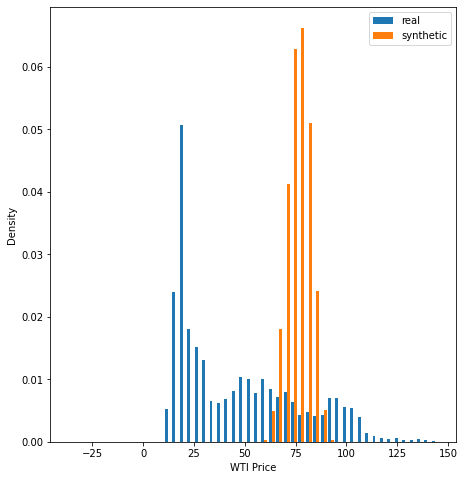

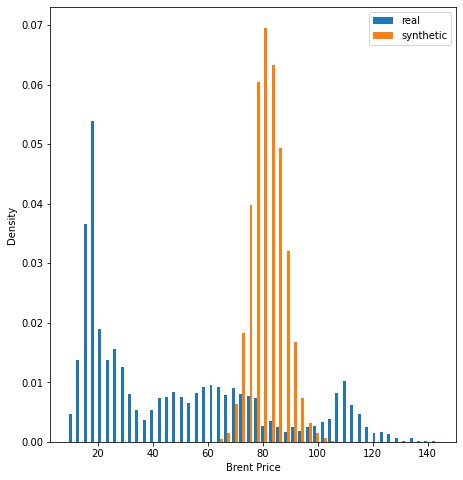

In [21]:
# Now, let's visualize the probability distribution of each feature and it's respective synthetic data alternate.
for val in list(df.iloc[:,1:].columns):
    plt.figure(figsize = (16,8))
    plt.subplot(1, 2, 1)
    plt.hist([np.array(df[val]), np.array(synthetic_df[val])], 
             label=["real", "synthetic"],
             bins=50,
             density=True,
             )
    plt.legend()
    plt.xlabel(val)
    plt.ylabel("Density")
    plt.show()

In [22]:
#Functions to calculate autocorrelation which will be visualized below.
def autocorr(X, Y):
    EPS = 1e-8
    Xm = torch.mean(X, 1).unsqueeze(1)
    Ym = torch.mean(Y, 1).unsqueeze(1)
    r_num = torch.sum((X - Xm) * (Y - Ym), 1)
    r_den = torch.sqrt(torch.sum((X - Xm)**2, 1) * torch.sum((Y - Ym)**2, 1))

    r_num[r_num == 0] = EPS
    r_den[r_den == 0] = EPS

    r = r_num / r_den
    r[r > 1] = 0
    r[r < -1] = 0

    return r
    
def get_autocorr(feature):
    feature = torch.from_numpy(feature)
    feature_length = feature.shape[1]
    autocorr_vec = torch.Tensor(feature_length - 2)

    for j in range(1, feature_length - 1):
      autocorr_vec[j - 1] = torch.mean(autocorr(feature[:, :-j], feature[:, j:]))

    return autocorr_vec.cpu().detach().numpy()

In [23]:
#function to generate numpy array in order to visualize the autocorrelation between real and synthetic data
def generate_numpy_for_autocorr(df, batch_size):
    features = df.iloc[: , 1:].to_numpy()
    n = features.shape[0] // batch_size

    # Shape is now (# examples, # time points, # features)
    features = features[:(n*batch_size),:].reshape(-1, batch_size, features.shape[1])
    return features

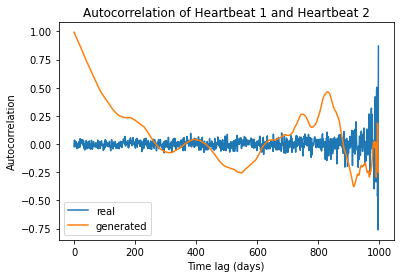

In [24]:
#Generate autocorrelation features from synthetic and real data and plot!
synthetic_acf = get_autocorr(generate_numpy_for_autocorr(df, seq_len))
acf = get_autocorr(generate_numpy_for_autocorr(synthetic_df, seq_len))
# Figure 1, autocorrelation
plt.plot(acf, label="real")
plt.plot(synthetic_acf, label="generated")
plt.xlabel("Time lag (days)")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of Heartbeat 1 and Heartbeat 2")
plt.legend()
plt.show()